# Testing regularization of likelihood functions

In [11]:
%pylab inline
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['laplace', 'time', 'gradient']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
sys.path.append('../../utils/flowpm/')

In [13]:
from matplotlib.colors import LogNorm

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [40]:
import numpy as np
import numpy, os
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from  astropy.cosmology import Planck15
from background import MatterDominated, RadiationDominated



def cic_paint(mesh, part, weight=None, cube_size=None, boxsize=None, name=None):
    """                                                                                                                                                                                                                                                                                   
        - mesh is a cube of format tf.Variable                                                                                                                                                                                                                                            
        - part is a list of particles (:, 3), positions assumed to be in                                                                                                                                                                                                                  
    mesh units if boxsize is None                                                                                                                                                                                                                                                         
        - weight is a list of weights (:)                                                                                                                                                                                                                                                 
        - cube_size is the size of the cube in mesh units                                                                                                                                                                                                                                 
    """

    if cube_size is None: cube_size = int(mesh.shape[0].value)
    if boxsize is not None:
        part = tf.multiply(part, cube_size/boxsize)

    # Extract the indices of all the mesh points affected by each particles                                                                                                                                                                                                               
    part = tf.expand_dims(part, 1)
    floor = tf.floor(part)
    connection = tf.constant([[[0, 0], [1.,0.], [0.,1.], [1.,1.]]])
    neighboor_coords = tf.add(floor, connection)

    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.mod(neighboor_coords , cube_size)

    update = tf.scatter_nd(neighboor_coords, kernel, [cube_size, cube_size])
    mesh = tf.add(mesh, update, name=name)
    return mesh

def cic_readout(mesh, part, cube_size=None, boxsize=None):
    """                                                                                                                                                                         
        - mesh is a cube                                                                                                                                                        
        - part is a list of particles (:, 3), positions assumed to be in                                                                                                        
    mesh units if boxsize is None                                                                                                                                               
        - cube_size is the size of the cube in mesh units                                                                                                                       
    """

    if cube_size is None: cube_size = int(mesh.shape[0].value)
    if boxsize is not None:
        part = tf.multiply(part, cube_size/boxsize)

    # Extract the indices of all the mesh points affected by each particles                                                                                                     
    part = tf.expand_dims(part, 1)
    floor = tf.floor(part)
    connection = tf.constant([[[0, 0], [1.,0.], [0.,1.], [1.,1.]]])
    neighboor_coords = tf.add(floor, connection)
    
    kernel = 1. - tf.abs(part - neighboor_coords)    
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    
    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.mod(neighboor_coords , cube_size)
    meshvals = tf.gather_nd(mesh, neighboor_coords)
#     return meshvals
    weightedvals = tf.multiply(meshvals, kernel)
    value = tf.reduce_sum(weightedvals, axis=1)
    return value

def laplace(config):
    kvec = config['kvec']
    kk = 0
    for k in config['kvec']:
        kk = kk + k**2
#     kk = np.sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1/kk
    imask = (~(kk==0)).astype(int)
    wts *= imask
    return wts



def gradient(config, dir):
    kvec = config['kvec']
    bs, nc = config['boxsize'], config['nc']
    cellsize = bs/nc
    w = kvec[dir] * cellsize
    a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
    wts = a*1j
    return wts


def r2c(rfield, norm=None, dtype=tf.complex64, name=None):
    if norm is None: norm = tf.cast(tf.reduce_prod(tf.shape(rfield)), dtype)
    else: norm = tf.cast(norm, dtype)
    cfield = tf.multiply(tf.spectral.fft2d(tf.cast(rfield, dtype)), 1/norm, name=name)
    return cfield


def c2r(cfield, norm=None, dtype=tf.float32, name=None):
    if norm is None: norm = tf.cast(tf.reduce_prod(tf.shape(cfield)), dtype)
    else: norm = tf.cast(norm, dtype)
    rfield = tf.multiply(tf.cast(tf.spectral.ifft2d(cfield), dtype), norm, name=name)
    return rfield


def fftk(shape, boxsize, symmetric=True, finite=False, dtype=np.float64):
    """ return k_vector given a shape (nc, nc, nc) and boxsize                                                                                                                  
    """
    k = []
    for d in range(len(shape)):
        kd = numpy.fft.fftfreq(shape[d])
        kd *= 2 * numpy.pi / boxsize * shape[d]
        kdshape = numpy.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) -1:
            kd = kd[:shape[d]//2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def genwhitenoise(nc, seed, type='complex'):
    if type == 'real': return white
    elif type == 'complex':
        whitec = r2c(white, norm=nc**2)
        return whitec


def linfield(config, seed=100, name='linfield'):
    '''generate a linear field with a given linear power spectrum'''

    bs, nc = config['boxsize'], config['nc']
    kmesh = 0
    for k in config['kvec']:
        kmesh = kmesh + k**2
    kmesh = kmesh**0.5
#     kmesh = np.sum(kk**2 for kk in config['kvec'])**0.5
    pkmesh = config['ipklin'](kmesh)

    whitec = genwhitenoise(nc, seed, type='complex')
    lineark = tf.multiply(whitec, (pkmesh/bs**3)**0.5)
    linear = c2r(lineark, norm=nc**2, name=name)
    return linear


def lpt1(dlin_k, pos, config):
    """ Run first order LPT on linear density field, returns displacements of particles                                                                                         
        reading out at q. The result has the same dtype as q.                                                                                                                   
    """
    bs, nc = config['boxsize'], config['nc']
    #ones = tf.ones_like(dlin_k)                                                                                                                                                
    lap = laplace(config)

    displacement = tf.zeros_like(pos)
    displacement = []
    for d in range(config['ndim']):
        kweight = gradient(config, d) * lap
        dispc = tf.multiply(kweight, dlin_k)
        disp = c2r(dispc, norm=nc**2)
        displacement.append(cic_readout(disp, pos, boxsize=bs))

    return tf.stack(displacement, axis=1)




def lptz0(lineark, config, a=1, order=2):
    '''one step 2 LPT displacement to z=0'''
    bs, nc = config['boxsize'], config['nc']
    pos = config['grid']

    DX1 = 1 * lpt1(lineark, pos, config)

    if order == 2: 
#         DX2 = 1 * tflpt1(tflpt2source(lineark, config), pos, config)
        return None
    else: DX2 = 0
    return tf.add(DX1 , DX2)


class Config2d(dict):
    def __init__(self, bs=100., nc=16, seed=100, B=1, stages=None, cosmo=None,
                 pkfile=None, pkinitfile=None, dtype=np.float32):

        self['dtype'] = dtype
        self['boxsize'] = dtype(bs)
        self['shift'] = 0.0
        self['nc'] = int(nc)
        self['kny'] = np.pi*nc/bs
        self['ndim'] = 2
        self['seed'] = seed
        self['pm_nc_factor'] = B
        self['resampler'] = 'cic'
        #                                                                                                                                                                       
        self['cosmology'] = Planck15
        if stages is None: stages = numpy.linspace(0.1, 1.0, 5, endpoint=True)
        self['stages'] = stages
        self['aout'] = [1.0]
        self['perturbation'] = MatterDominated(cosmo=self['cosmology'], a=self['stages'])
        #self['perturbation'] = RadiationDominated(cosmo=self['cosmology'], a=self['stages'])                                                                                   
        #                                                                                                                                                                       
        self['kvec'] = fftk(shape=(nc,nc), boxsize=bs, symmetric=False, dtype=dtype)
        self['grid'] = bs/nc*np.indices((nc, nc)).reshape(2, -1).T.astype(dtype)
        self['pkfile'] = '../../utils/flowpm/Planck15_a1p00.txt'
        self['klin'] = np.loadtxt(self['pkfile']).T[0]
        self['plin'] = np.loadtxt(self['pkfile']).T[1]
        self['ipklin'] = iuspline(self['klin'], self['plin'])
        #                                                        

In [41]:
from time import time

In [42]:
# start = time()
# tf.reset_default_graph()
# inits, fins = [], []

# bs = 100.
# nc = 100
# config = Config1d(bs=bs, nc=nc)
# for ii in range(1):
#     if ii%1000==0: print(ii)
#     tf.reset_default_graph()
#     lf_t = linfield(config, seed=ii)
#     lfk_t = r2c(lf_t, norm=nc)
#     za_t = lptz0(lfk_t, config, order=1)
#     final_t = tf.zeros_like(lf_t)
#     zaf_t = cic_paint(final_t, za_t, boxsize=bs, name='final')
#     test = cic_readout(lf_t, config['grid'],cube_size=nc, boxsize=bs)
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
#         lf = sess.run(lf_t)
#         za = sess.run(za_t)
#         zaf = sess.run(zaf_t)
#         test = sess.run(test)
# #     inits.append(lf.copy())
# #     fins.append(za.copy())


# # print(time() - start)

In [43]:
tf.reset_default_graph()

bs = 100.
nc = 32
config = Config2d(bs=bs, nc=nc)
kmesh = 0
for k in config['kvec']:
    kmesh = kmesh + k**2
kmesh = kmesh**0.5
#     kmesh = np.sum(kk**2 for kk in config['kvec'])**0.5
pkmesh = config['ipklin'](kmesh)


def module_fn():
    '''Define network here'''
    init = tf.placeholder(tf.float32, shape=[nc, nc], name='input')
    
    init_k = r2c(init, norm=nc**2)
    init_kp = tf.multiply(init_k,  (pkmesh/bs**3)**0.5)
    lin = c2r(init_kp, norm=nc**2)
    lap = laplace(config)
    displacement = []
    for d in range(2):
        kweight = gradient(config, d) * lap
        dispc = tf.multiply(kweight, init_kp)
        disp = c2r(dispc, norm=nc**2)
        displacement.append(cic_readout(disp, config['grid'], boxsize=bs))
    za_t = tf.stack(displacement, axis=1)    
#     za_t = lptz0(init_k, config, order=1)
    
    fp_t = tf.add(za_t, config['grid'])
    zaf_t = tf.zeros_like(init)
    zaf_t = cic_paint(zaf_t, fp_t, boxsize=bs, name='final')
    test_rd = cic_readout(lin, config['grid'], boxsize=bs)
    test_pt = tf.zeros_like(init)
    test_pt = cic_paint(test_pt, config['grid'], weight=test_rd, boxsize=bs)
    
    #

    hub.add_signature(inputs={'init':init}, 
                          outputs={'linfield':lin, 'zadisp':za_t, 'zafield':zaf_t, 
                                   'testpt':test_pt, 'testrd':test_rd, 'disp':disp})
    
#####


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[nc, nc], name='input')
linf_t = module({'init':xx}, as_dict=True)['linfield']
zaf_t = module({'init':xx}, as_dict=True)['zafield']
zad_t = module({'init':xx}, as_dict=True)['zadisp']
disp_t = module({'init':xx}, as_dict=True)['disp']
test_pt = module({'init':xx}, as_dict=True)['testpt']
test_rd = module({'init':xx}, as_dict=True)['testrd']


data_size = 5000
initgs = np.random.normal(loc=0, scale=nc**1., size = nc**2*data_size)
initgs = initgs.astype('float32').reshape(data_size, nc,nc)
fins = []
lins = []
za = []
tests = []
start = time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for ii in range(data_size):
#         lin = sess.run([linf_t], feed_dict={xx:initgs[ii]})
        lin, fin, disp = sess.run([linf_t, zaf_t,  zad_t], feed_dict={xx:initgs[ii]})
        lins.append(lin)
        fins.append(fin-1)
        za.append(disp)
#         tests.append(sess.run([test_pt, test_rd], feed_dict={xx:initgs[ii]}))
        
print(time() - start)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
23.907471179962158


In [ ]:
# n, k = np.histogram(kmesh.flatten(), bins=50)
# p, k = np.histogram(kmesh.flatten(), bins=50, weights=pkmesh.flatten())
# plt.plot(k[:-1], p/n)
# plt.loglog()

In [44]:
lins = np.array(lins)
fins = np.array(fins)
za = np.array(za)
print(za.max())

14.401251


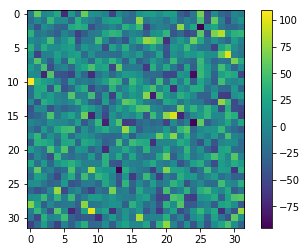

In [45]:
plt.imshow(initgs[0])
plt.colorbar()

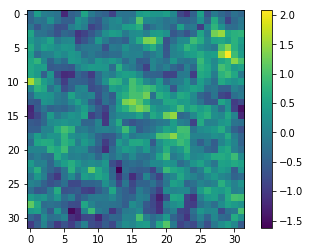

In [46]:
plt.imshow(lins[0])
plt.colorbar()

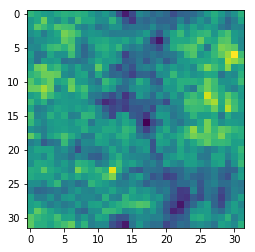

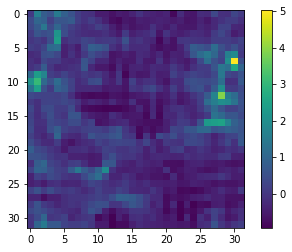

In [47]:
ii = 5
# plt.plot(initgs[ii], ':')
plt.imshow(lins[ii])
plt.show()
plt.imshow(fins[ii])
plt.colorbar()

In [48]:
np.save('./za2d_data', np.stack((lins, fins)))

In [49]:
inits, fins = np.load('./za2d_data.npy')
nc = inits.shape[1]

In [50]:
inits.shape, fins.shape

((5000, 32, 32), (5000, 32, 32))

In [186]:
# for ii in range(5):
#     plt.plot(lins[ii], 'C%d'%ii)
#     plt.plot(fins[ii], 'C%d--'%ii)


In [31]:
%%bash
ls ./modules/
# rm -r ./modules/fwdmodelza2d/


densemodule
densemoduleza
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [32]:
module.export('./modules/fwdmodelza2d', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/fwdmodelza2d


# Module

Train a neural network in a module 

In [22]:
# tf.reset_default_graph()

# nsize = 256

# def module_fn():
#     '''Define network here'''
#     x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
#     y = tf.placeholder(tf.float32, shape=[None, nc], name='output')

#     reg = tf.contrib.layers.l2_regularizer(0.01)

# #     net = tf.layers.dense(x,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# #     net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# #     net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# # #     net = tf.layers.dense(net,nc, activation=tf.nn.leaky_relu, name='rate')
# #     net = tf.layers.dense(net,nc,  name='rate')

#     xx = tf.expand_dims(x, -1)
#     net = tf.layers.conv1d(xx,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8,3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = tf.layers.conv1d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = tf.squeeze(net, name='rate')
# #     net = tf.layers.flatten(net)
# #     net = tf.layers.dense(net, nc, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# #     net = tf.layers.dense(net, nc,  name='rate')
# #     net = tf.layers.dense(net,nc, activation=tf.nn.leaky_relu, name='rate')
#     loglik = tf.reduce_sum(tf.square(tf.add(net, -y)), axis=(1))
#     #

#     hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':net, 'loglikelihood':loglik, 'rate':net})
    
# #####                                                                                                                                                                                                                                                                                     


# spec = hub.create_module_spec(module_fn)
# module = hub.Module(spec, trainable=True)


# xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
# loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
# sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
# loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
# loss = tf.reduce_mean(loss)

# lr = tf.placeholder(tf.float32)
# optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# train_op = optimizer.minimize(loss)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# losses =[]

# data_size = 9000
# batch_size = 32

# for i in range(5000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]/fins.std()
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.01})
#     losses.append(l)
#     if i%1000 ==0: print(l)
# for i in range(10000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]/fins.std()
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
#     losses.append(l)
#     if i%1000 ==0: print(l)
        
# # for i in range(5000):
# #     inds = np.random.randint(0, data_size, batch_size)
# #     l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.0005})
# #     losses.append(l)
# #     if i%1000 ==0: print(l)
# # pred = sess.run(sample, feed_dict={xx:sx})
# learn = sess.run(rate, feed_dict={xx:inits, yy:y})


In [89]:

tf.reset_default_graph()


nfilter = 32
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.00)

    xx = tf.expand_dims(x, -1)
    net = tf.layers.conv2d(xx,nfilter, 5, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv2d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv2d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv2d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv2d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv2d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv2d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv2d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv2d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.layers.conv2d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    net = tf.layers.conv2d(net,1, 1, kernel_regularizer=reg,padding='same')
    net = tf.squeeze(net, name='rate')

    loglik = tf.reduce_sum(tf.square(tf.add(net, -y)), axis=(1, 2))

    #

    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':net, 'loglikelihood':loglik, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 4000
batch_size = 128

for i in range(1000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append( l)   
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
        
learn = sess.run(rate, feed_dict={xx:inits, yy:y})


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
372.78467
106.002625
103.34875
92.27159
90.57489
87.78476
90.40052
94.81633


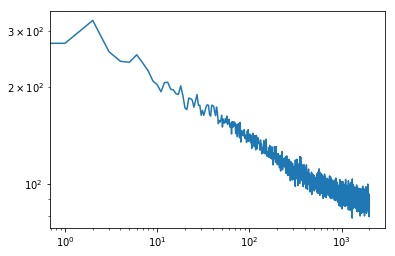

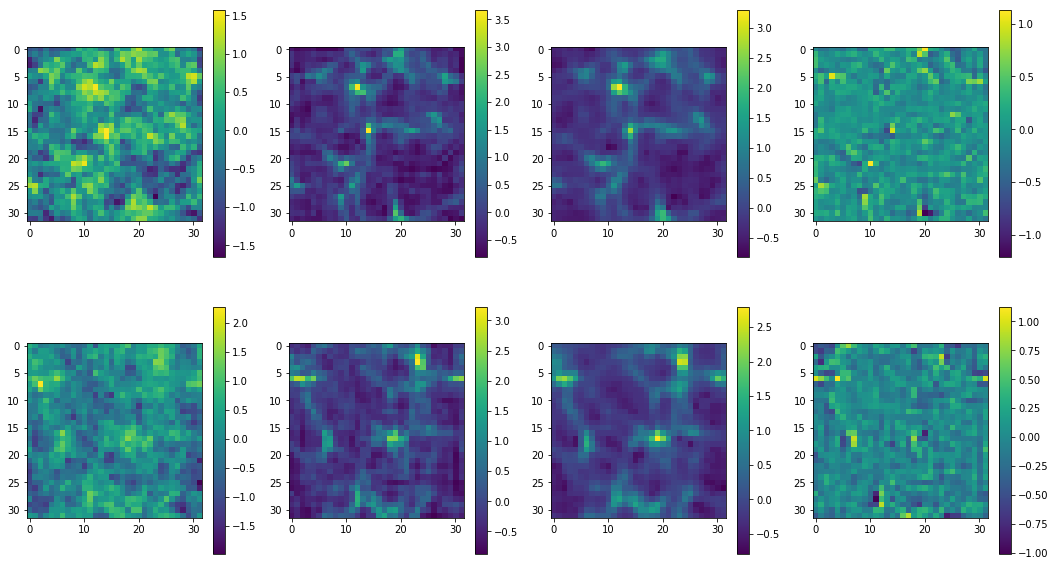

In [90]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 990
axis = ax[0]
im = axis[0].imshow(inits[ii])
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii])
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii])
colorbar(im, ax=axis[2])
im = axis[3].imshow(fins[ii] - learn[ii])
colorbar(im, ax=axis[3])
ii = 4900
axis = ax[1]
im = axis[0].imshow(inits[ii])
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii])
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii])
colorbar(im, ax=axis[2])
im = axis[3].imshow(fins[ii] - learn[ii])
colorbar(im, ax=axis[3])


In [91]:
%%bash
ls modules/
rm -r ./modules/densemoduleza2d


densemodule
densemoduleza
densemoduleza2d
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [92]:
module.export('./modules/densemoduleza2d', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemoduleza2d


# Reconstruct here

In [96]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def dorecon(yy, xinit, modname, useprior=True, niter=5000, lr=0.001):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    loglik = module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']

    xreconk = r2c(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(1, 2))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [114]:
tf.reset_default_graph()
modname = './modules/densemoduleza2d//'
xrecons = []
losses = []
priors = []
xinit = []

nstart = 50

ir = [4700]
for ii in ir:
#     ii = 2*i
    seed(100)
    yy = np.array([fins[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn(nstart, nc, nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=3000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xrecons.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("module_apply_default/Sum:0", shape=(50,), dtype=float32) Tensor("prior:0", shape=(50,), dtype=float32)
489.47433
107.61804
69.075714
56.759064
48.729633
46.740154
44.010365
43.648575
38.691288
39.561363
38.812813
35.666824
37.672604
36.221527
35.307648
34.084797
33.074142
32.448994
34.243446
33.052914
33.146698
32.18032
31.75515
30.191683
31.13505
29.365812
30.785898
30.501238
29.61946
31.102724
29.307184


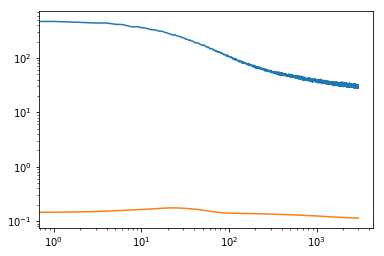

In [115]:
ii = 0
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')


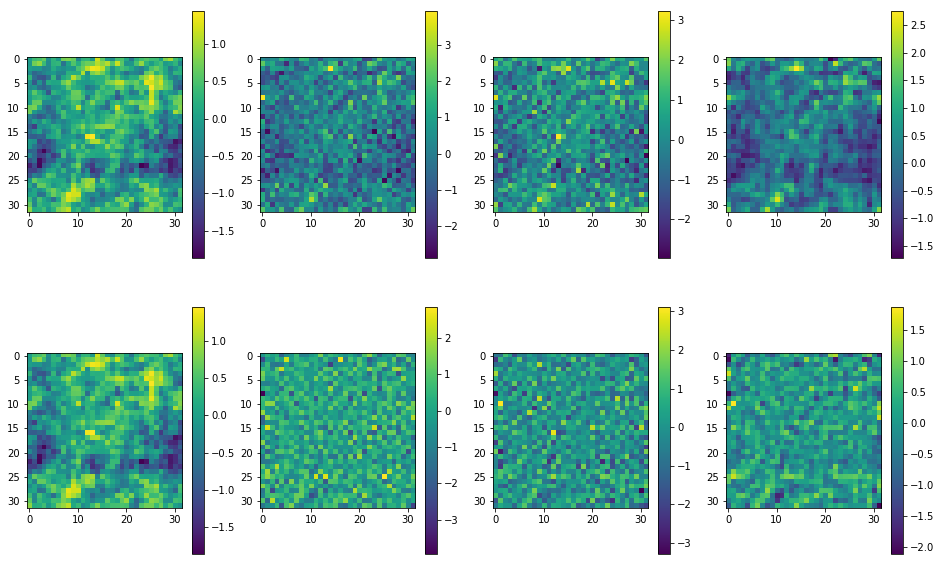

In [117]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]])
colorbar(im, ax=ax[0])
im = ax[1].imshow(xrecons[0][0])
colorbar(im, ax=ax[1])
im = ax[2].imshow(xrecons[0][25])
colorbar(im, ax=ax[2])
im = ax[3].imshow(xrecons[0].mean(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]])
colorbar(im, ax=ax[0])
im = ax[1].imshow(inits[ir[0]]-xrecons[0][0])
colorbar(im, ax=ax[1])
im = ax[2].imshow(inits[ir[0]]-xrecons[0][25])
colorbar(im, ax=ax[2])
im = ax[3].imshow(inits[ir[0]]-xrecons[0].mean(axis=0))
colorbar(im, ax=ax[3])


In [458]:
tf.reset_default_graph()
module = hub.Module(modname, trainable=False)

xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']

sess = tf.Session()
sess.run(tf.global_variables_initializer())
reconfins = sess.run(rate, feed_dict={xx:xrecons[0], yy:y})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


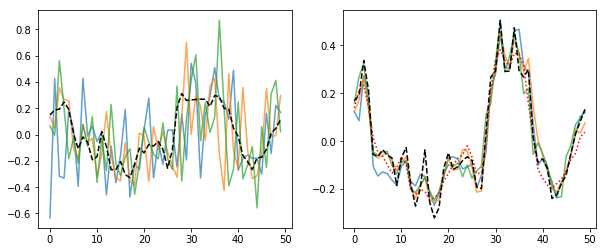

In [459]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xrecons[0][ii], alpha=0.7)
axis.plot(inits[ir[0]], 'k--')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfins[ii], alpha=0.7)
plt.plot(learn[ir[0]], 'r:')
plt.plot(fins[ir[0]], 'k--')

### Reconstruct with true model

In [310]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def doreconanalytic(yy, xinit, modname, useprior=True, niter=5000, lr=0.001):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    xreconk = r2c(xrecon)    
    lap = laplace(config)
    kweight = gradient(config, 0) * lap
    dispc = tf.multiply(kweight, xreconk)
    disp = c2r(dispc)
    za_t = tf.stack([cic_readout(disp, config['grid'], boxsize=bs)], axis=1)    
    
    fp_t = tf.add(za_t, config['grid'])
    zaf_t = tf.zeros_like(xrecon)
    zaf_t = cic_paint(zaf_t, fp_t, boxsize=bs, name='final')
    
    predict = tf.add(zaf_t, -1.)
    
    loglik = tf.reduce_sum(tf.square(tf.add(predict, -yy)), axis=(-1))

    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=-1)
    prior = tf.multiply(prior, 1/nc, name='prior')


    if useprior: loss = tf.add(loglik, prior)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%1000==0: print(l)
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
        
#         xfin, llik, pr = sess.run([predict, loglik, prior])
        
#     return xfin, llik, pr


tf.reset_default_graph()
modname = './modules/fwdmodelza//'
xreconstrue = []
losses = []
priors = []
xinittrue = []

nstart = 1

ir = [9500]
for ii in ir:
#     ii = 2*i
    seed(100)
#     yy = np.array([fins[ii].copy() for j in range(nstart)])
    yy = fins[ii].copy()
    for j in range(10):
        print('Iteration : ', j)
        xi = randn(nc)
#         xi = inits[ii].copy()
        xi = xi.astype('float32')
        recons = doreconanalytic(yy, xi, modname, useprior=True, niter=5000, lr=0.001)
        recons2 = doreconanalytic(yy, recons[0], modname, useprior=True, niter=5000, lr=0.0005)
        xrecon = np.squeeze(recons2[0])
        xreconstrue.append(xrecon)
        losses.append(np.squeeze(recons[1] + recons2[1]))
        priors.append(np.squeeze(recons[2] + recons2[2]))
        xinittrue.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


333.07837
2.2568269
0.814492
0.80880374
0.8087417
0.8087414
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.8087412
0.80874026
0.8087407
0.80874145
0.80874145
0.80874145
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
1343.4547
0.93209636
0.8250244
0.8244636
0.82445884
0.82446027
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.82445943
0.8244588
0.82445717
0.8244569
0.8244581
0.82445824
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
3366.522
1.2375374
0.91228634
0.91133463
0.9113296
0.9113295
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.91132957
0.9113282
0.9113283
0.91132885
0.91132885
0.91132885
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
1154.8785
1.6156788
0.82817405
0.82805
0.8280513
0.8280549
INFO:tensorflow:Saver not create

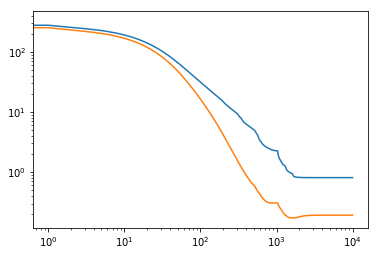

In [314]:
plt.plot(losses[0])
plt.plot(priors[0])
plt.yscale('log')
plt.xscale('log')

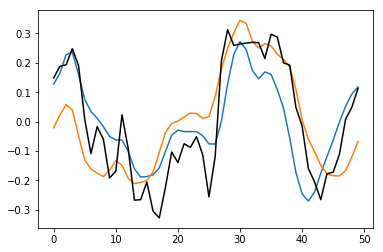

In [315]:
plt.plot(xreconstrue[0])
plt.plot(xreconstrue[1])
# plt.plot(xreconstrue[0])
plt.plot(inits[ir[0]], 'k', lw=1.5, label='truth')
# plt.plot(fins[ir[0]], 'b:', lw=1.5, label='truth')


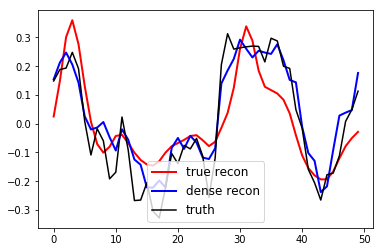

In [326]:
plt.plot(np.array(xreconstrue).mean(axis=0), lw=2, color='red', label='true recon')
plt.plot(xrecons[0].T.mean(axis=-1), lw=2, color='blue', label='dense recon')
plt.plot(inits[ir[0]], 'k', lw=1.5, label='truth')
plt.legend(fontsize=12)
plt.show()

# Custom dense layer

In [120]:
tf.glorot_normal_initializer()

In [124]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv2d as specconv2d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 32
num_iters = 1
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc], name='output')

    xx = tf.expand_dims(x, -1)

    net = specconv2d(xx, nfilter, 5, num_iters=num_iters)
    net = activation=tf.nn.leaky_relu(net)

    net = tf.nn.leaky_relu(net)
    subnet = specconv2d(net, nfilter, 3, name='l11', num_iters=num_iters)
    net = net + specconv2d(subnet,nfilter, 3, name='l12', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv2d(net, nfilter, 3, name='l21', num_iters=num_iters)
    net = net + specconv2d(subnet,nfilter, 3, name='l22', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv2d(net, nfilter, 3, name='l31', num_iters=num_iters)
    net = net + specconv2d(subnet,nfilter, 3, name='l32', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv2d(net, nfilter, 3, name='l41', num_iters=num_iters)
    net = net + specconv2d(subnet,nfilter, 3, name='l42', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = specconv2d(net,1, 3, name='l51', num_iters=num_iters)
    net = tf.nn.leaky_relu(net)
    net = specconv2d(net,1, 1, name='l61', num_iters=num_iters)
    net = tf.squeeze(net, name='rate')

    
    loglik = tf.reduce_sum(tf.square(tf.add(net, -y)), axis=(1, 2))

    #

    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':net, 'loglikelihood':loglik, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 4500
batch_size = 128

for i in range(1000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(1000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(1000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

        
        
learnspec = sess.run(rate, feed_dict={xx:inits, yy:y})


../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
473.4932
113.49694
96.572266
96.49779
90.55946
85.82515
88.74103
85.24199
82.36197
96.7932
87.86603
89.02806


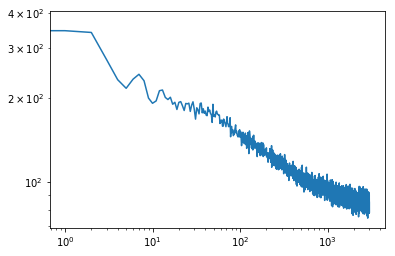

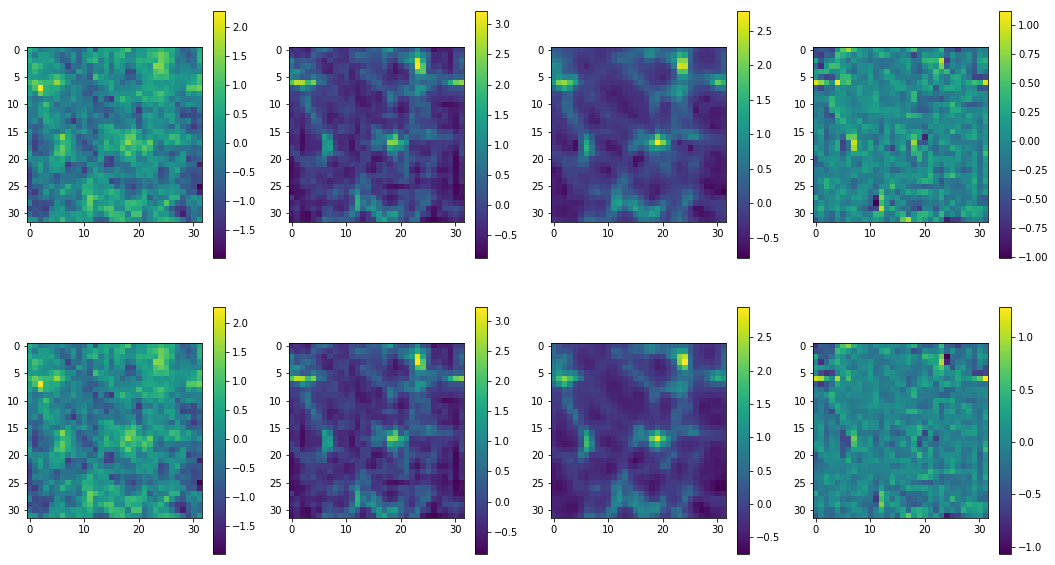

In [129]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 4900
axis = ax[0]
im = axis[0].imshow(inits[ii])
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii])
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii])
colorbar(im, ax=axis[2])
im = axis[3].imshow(fins[ii] - learn[ii])
colorbar(im, ax=axis[3])
ii = 4900
axis = ax[1]
im = axis[0].imshow(inits[ii])
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii])
colorbar(im, ax=axis[1])
im = axis[2].imshow(learnspec[ii])
colorbar(im, ax=axis[2])
im = axis[3].imshow(fins[ii] - learnspec[ii])
colorbar(im, ax=axis[3])


In [538]:
%%bash
ls ./modules/
rm -r ./modules/specdensemoduleza2d


densemodule
densemoduleza
fwdmodelza
specdensemodule
specdensemoduleza


In [126]:
module.export('./modules/specdensemoduleza2d', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemoduleza2d


## recon again 

In [130]:
tf.reset_default_graph()
modname = './modules/densemoduleza2d//'
xreconsspec = []
losses = []
priors = []
xinitspec = []

nstart = 50
ir = [4700]

for ii in ir:
#     ii = 2*i
    seed(100)
    yy = np.array([fins[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn(nstart, nc, nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=3000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xreconsspec.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinitspec.append(xi)




INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("module_apply_default/Sum:0", shape=(50,), dtype=float32) Tensor("prior:0", shape=(50,), dtype=float32)
482.99496
104.737526
64.8518
56.774597
51.304543
45.54833
43.621517
41.660545
42.872883
39.753445
39.317066
38.10458
34.47947
35.795002
34.949177
35.668686
33.823048
33.553
32.89111
34.16793
32.060825
32.332344
31.533274
31.78746
31.747007
29.483973
30.745857
31.258741
29.768223
28.77275
28.192919


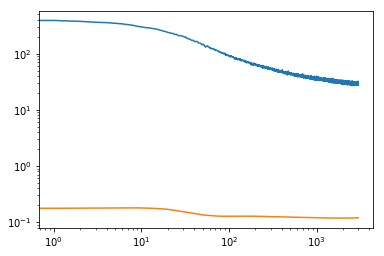

In [133]:
ii = 5
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')
plt.show()


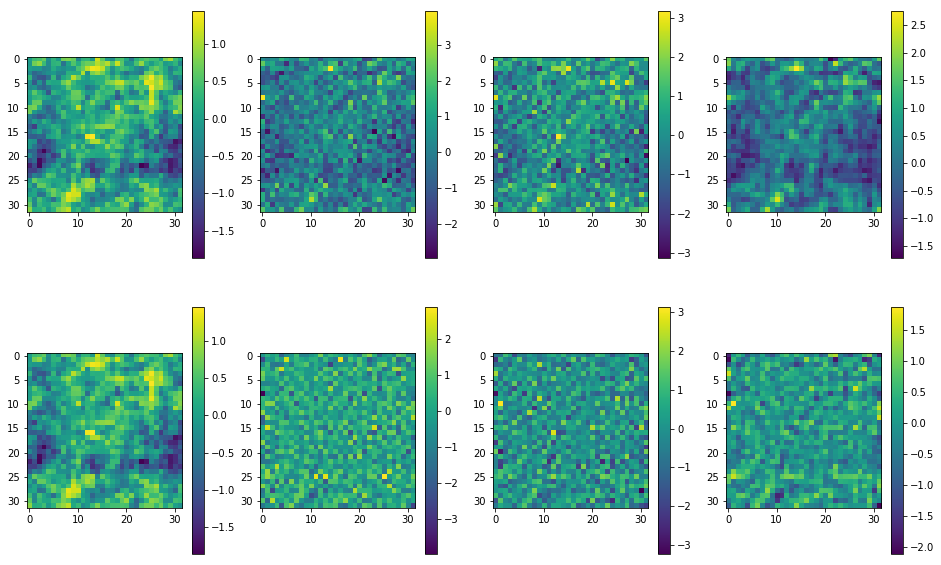

In [134]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]])
colorbar(im, ax=ax[0])
im = ax[1].imshow(xreconsspec[0][0])
colorbar(im, ax=ax[1])
im = ax[2].imshow(xreconsspec[0][25])
colorbar(im, ax=ax[2])
im = ax[3].imshow(xreconsspec[0].mean(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]])
colorbar(im, ax=ax[0])
im = ax[1].imshow(inits[ir[0]]-xreconsspec[0][0])
colorbar(im, ax=ax[1])
im = ax[2].imshow(inits[ir[0]]-xreconsspec[0][25])
colorbar(im, ax=ax[2])
im = ax[3].imshow(inits[ir[0]]-xreconsspec[0].mean(axis=0))
colorbar(im, ax=ax[3])


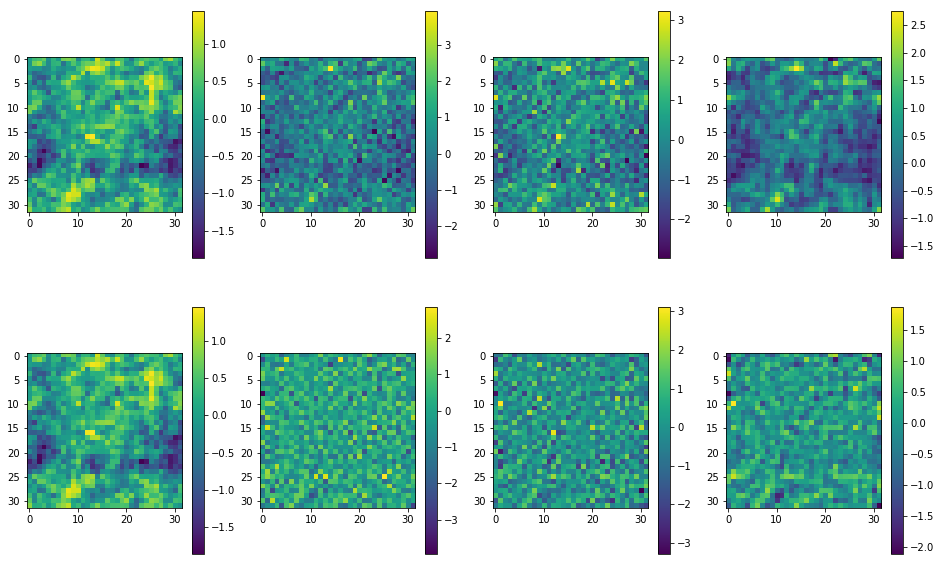

In [135]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]])
colorbar(im, ax=ax[0])
im = ax[1].imshow(xrecons[0][0])
colorbar(im, ax=ax[1])
im = ax[2].imshow(xrecons[0][25])
colorbar(im, ax=ax[2])
im = ax[3].imshow(xrecons[0].mean(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]])
colorbar(im, ax=ax[0])
im = ax[1].imshow(inits[ir[0]]-xrecons[0][0])
colorbar(im, ax=ax[1])
im = ax[2].imshow(inits[ir[0]]-xrecons[0][25])
colorbar(im, ax=ax[2])
im = ax[3].imshow(inits[ir[0]]-xrecons[0].mean(axis=0))
colorbar(im, ax=ax[3])


In [555]:
tf.reset_default_graph()
module = hub.Module(modname, trainable=False)

xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']

sess = tf.Session()
sess.run(tf.global_variables_initializer())
reconfinsspec = sess.run(rate, feed_dict={xx:xreconsspec[0], yy:y})



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


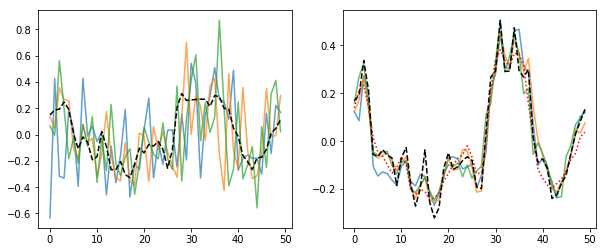

In [556]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xrecons[0][ii], alpha=0.7)
axis.plot(inits[ir[0]], 'k--')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfins[ii], alpha=0.7)
plt.plot(learn[ir[0]], 'r:')
plt.plot(fins[ir[0]], 'k--')

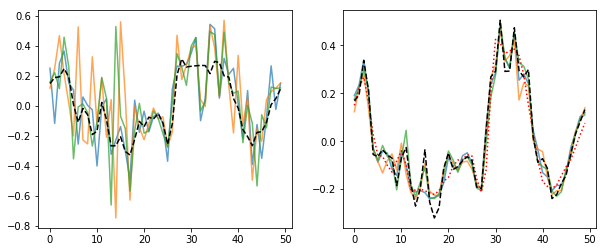

In [557]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xreconsspec[0][ii], alpha=0.7)
axis.plot(inits[ir[0]], 'k--')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfinsspec[ii], alpha=0.7)
plt.plot(learnspec[ir[0]], 'r:')
plt.plot(fins[ir[0]], 'k--')

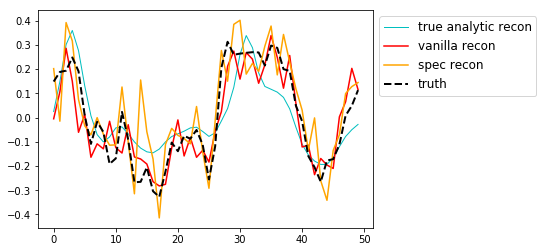

In [558]:
plt.plot(np.array(xreconstrue).mean(axis=0), lw=1, color='c', label='true analytic recon')
plt.plot(xrecons[0].T.mean(axis=-1), lw=1.5, color='red', label='vanilla recon')
plt.plot(xreconsspec[0].T.mean(axis=-1), lw=1.5, color='orange', label='spec recon')
plt.plot(inits[ir[0]], 'k--', lw=2, label='truth')
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Text(0.5, 1.0, 'Different spec normed recons')

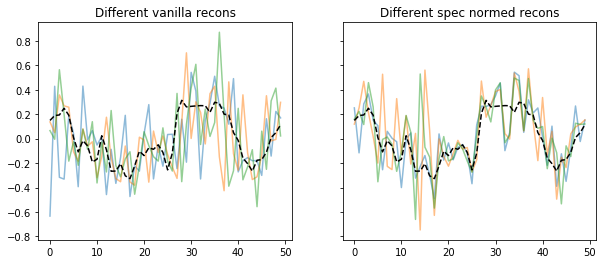

In [564]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xrecons[0][ii], alpha=0.5)
axis.plot(inits[ir[0]], 'k--')
axis.set_title('Different vanilla recons')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(xreconsspec[0][ii], alpha=0.5)
axis.plot(inits[ir[0]], 'k--')
axis.set_title('Different spec normed recons')

In [565]:
print(np.corrcoef(inits[ir[0]], xreconsspec[0].T.mean(axis=-1)))
print(np.corrcoef(inits[ir[0]], xrecons[0].T.mean(axis=-1)))

[[1.         0.85817184]
 [0.85817184 1.        ]]
[[1.         0.88353544]
 [0.88353544 1.        ]]


# From samples generated by the learned networks

In [561]:
tf.reset_default_graph()
modname = './modules/densemoduleza/'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[0]
    print(var)
    kern = sess.run(var)

tf.reset_default_graph()
modname = './modules/specdensemoduleza//'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[0]
    print(var)
    kernspec = sess.run(var)
# tf.get_collection('variables')


<tf.Variable 'module/conv1d/kernel:0' shape=(5, 1, 128) dtype=float32>
<tf.Variable 'module/conv1d/w:0' shape=(5, 1, 128) dtype=float32>


In [562]:
def l2normalize(v, eps=1e-12):
    return v / (np.sum(v ** 2) ** 0.5 + eps)

def poweriter(W):
    W_shape = list(W.shape)
    W_reshaped = np.reshape(W, [-1, W_shape[-1]])
    u = np.random.normal(size=W.shape[-1]).reshape(1, W.shape[-1])
    for i in range(100):
        v = l2normalize(np.matmul(u, np.transpose(W_reshaped)))
        u = l2normalize(np.matmul(v, W_reshaped))

    return np.matmul(np.matmul(v, W_reshaped), np.transpose(u))


poweriter(kern) , poweriter(kernspec)

(array([[0.83871564]]), array([[0.85677522]]))

In [563]:


poweriter(kern) , poweriter(kernspec)

(array([[0.83871564]]), array([[0.85677211]]))